# Graph Transformer For ZINC Dataset

In [ ]:
!pip uninstall torch -y
!pip install torch==2.4.0

  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl (797.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.4.0 which is incompatible.
torchvision 0.20.1+cu121 requires torch==2.5.1, but you have torch 2.4.0 which is incompatible.


In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['DGLBACKEND'] = "pytorch"

# Uncomment below to install required packages. If the CUDA version is not 11.8,
# check the https://www.dgl.ai/pages/start.html to find the supported CUDA
# version and corresponding command to install DGL.
#!pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html > /dev/null
#!pip install ogb >/dev/null

!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html
!pip install ogb

try:
    import dgl
    installed = True
except ImportError:
    installed = False
print("DGL installed!" if installed else "Failed to install DGL!")

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.2 MB/s eta 0:00:00


KeyboardInterrupt: 

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['DGLBACKEND'] = "pytorch"
import dgl

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.2 MB/s eta 0:00:00


## Multi-head Attention

In [ ]:
import dgl
import dgl.nn as dglnn
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dgl.data import AsGraphPredDataset
from dgl.dataloading import GraphDataLoader
from ogb.graphproppred import collate_dgl, DglGraphPropPredDataset, Evaluator
from ogb.graphproppred.mol_encoder import AtomEncoder
from tqdm import tqdm


class MHA(nn.Module):

    def __init__(self, hidden_size=80, num_heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.scaling = self.head_dim**-0.5

        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        self.e_proj = nn.Linear(hidden_size, hidden_size)  # Adjust projection size
        self.out_proj = nn.Linear(self.num_heads * self.head_dim, hidden_size)


    def forward(self, A, h, edge_feats):
        N = h.size(0)
        E = edge_feats.size(0)

        # Project node features
        q = self.q_proj(h).reshape(N, self.num_heads, self.head_dim)
        q *= self.scaling
        k = self.k_proj(h).reshape(N, self.num_heads, self.head_dim)
        v = self.v_proj(h).reshape(N, self.num_heads, self.head_dim)

        # Project edge features
        e = self.e_proj(edge_feats)  # Shape: [E, hidden_size]

        # Extract edge indices
        edge_indices = A.indices()
        src = edge_indices[0]
        dst = edge_indices[1]

        # Attention logic
        attn_scores_list = []
        for head in range(self.num_heads):
            q_head = q[:, head, :]
            k_head = k[:, head, :]

            q_edges = q_head[src]
            k_edges = k_head[dst]

            attn_scores = (q_edges * k_edges).sum(dim=-1)  # Shape: [E]
            attn_scores *= e[:, head]
            attn_scores = attn_scores.softmax(dim=0)
            attn_scores_list.append(attn_scores)

        attn = torch.stack(attn_scores_list, dim=1)

        # Aggregate features
        out_list = []
        for head in range(self.num_heads):
            v_head = v[:, head, :]
            v_edges = v_head[src] * attn[:, head].unsqueeze(-1)
            out = torch.zeros_like(v_head).scatter_add_(0, dst.unsqueeze(-1).expand_as(v_edges), v_edges)
            out_list.append(out)

        out = torch.cat(out_list, dim=1)
        node_features = self.out_proj(out)

        # Adjust edge_scores shape to match hidden_size
        edge_scores = self.out_proj(e)

        return node_features, edge_scores

## Graph Transformer Layer

In [ ]:
class GTLayer(nn.Module):

    def __init__(self, hidden_size=80, num_heads=8):
        super().__init__()
        self.MHA = MHA(hidden_size=hidden_size, num_heads=num_heads)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)
        self.FFN1 = nn.Linear(hidden_size, hidden_size * 2)
        self.FFN2 = nn.Linear(hidden_size * 2, hidden_size)
        self.edge_batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.edge_batchnorm2 = nn.BatchNorm1d(hidden_size)
        self.edge_FFN1 = nn.Linear(hidden_size, hidden_size * 2)
        self.edge_FFN2 = nn.Linear(hidden_size * 2, hidden_size)


    def forward(self, A, h, edge_feats):
        h1 = h
        #print("in gt layer edge features shape is", edge_feats.shape)

        # Multi-head attention
        h, edge_scores = self.MHA(A, h, edge_feats)

        # Batch normalization and residual connection
        h = self.batchnorm1(h + h1)

        h2 = h
        h = self.FFN2(F.relu(self.FFN1(h)))
        h = self.batchnorm2(h + h2)

        # Handle edge features
        edge_features1 = edge_feats
        edge_features = self.edge_FFN2(F.relu(self.edge_FFN1(edge_scores)))
        edge_features = self.edge_batchnorm2(edge_features + edge_features1)

        return h

## Graph Transformer Model

In [ ]:
class GTModel(nn.Module):
    def __init__(
        self,
        out_size,
        hidden_size=60,
        pos_enc_size=2,
        num_layers=4,
        num_heads=4,
        num_bond_types=4,
    ):
        super().__init__()
        self.atom_encoder = AtomEncoder(hidden_size)
        self.pos_linear = nn.Linear(pos_enc_size, hidden_size)
        self.edge_linear = nn.Linear(num_bond_types, hidden_size)
        self.layers = nn.ModuleList(
            [GTLayer(hidden_size, num_heads) for _ in range(num_layers)]
        )
        self.pooler = dglnn.SumPooling()
        self.predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, out_size),
        )

    def forward(self, g, X, pos_enc, edge_feats):
        indices = torch.stack(g.edges())
        N = g.num_nodes()
        A = dglsp.spmatrix(indices, shape=(N, N))
        if X.ndimension() == 1:
            X = X.view(-1, 1)  # Reshape X to [num_nodes, feature_size]
        # Reduce positional encoding to match the required size using a linear layer
        pos_enc = self.pos_linear(pos_enc)  # Transform pos_enc to match the hidden_size
        edge_embeds = self.edge_linear(edge_feats)
        #print("edge embedding shape is" ,edge_embeds.shape)
        h = self.atom_encoder(X) + pos_enc
        for layer in self.layers:
            h = layer(A, h, edge_embeds)
        h = self.pooler(g, h)

        return self.predictor(h)

## Training

We train the GT model on [ogbg-molhiv](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) benchmark. The Laplacian positional encoding of each graph is pre-computed (with the API [here](https://docs.dgl.ai/en/latest/generated/dgl.laplacian_pe.html)) as part of the input to the model.

*Note that we down-sample the dataset to make this demo runs faster. See the* [*example script*](https://github.com/dmlc/dgl/blob/master/examples/sparse/graph_transformer.py) *for the performance on the full dataset.*

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from dgl.data import ZINCDataset
from dgl.dataloading import GraphDataLoader
from sklearn.metrics import mean_squared_error
import numpy as np
import random


train_dataset = ZINCDataset(mode="train")  # Load training data by default
valid_dataset = ZINCDataset(mode="valid")
test_dataset = ZINCDataset(mode="test")

# Print dataset statistics
print(f"Number of atom types: {train_dataset.num_atom_types}")
print(f"Number of bond types: {train_dataset.num_bond_types}")
print(f"Total number of samples: {len(train_dataset)}")

# Set random seed for reproducibility
random.seed(42)

# Laplacian Positional Encoding (optional, but keeping for consistency)
pos_enc_size = 2  # Size of positional encoding

# Apply Laplacian positional encoding for each graph
for g, label in train_dataset:
    g.ndata["PE"] = dgl.laplacian_pe(g, k=pos_enc_size, padding=True)  # Compute PE

# Apply Laplacian positional encoding for each graph
for g, label in valid_dataset:
    g.ndata["PE"] = dgl.laplacian_pe(g, k=pos_enc_size, padding=True)  # Compute PE

# Apply Laplacian positional encoding for each graph
for g, label in test_dataset:
    g.ndata["PE"] = dgl.laplacian_pe(g, k=pos_enc_size, padding=True)  # Compute PE






Number of atom types: 28
Number of bond types: 4
Total number of samples: 10000


/usr/local/lib/python3.10/dist-packages/dgl/transforms/functional.py:3725: DGLWarning: dgl.laplacian_pe will be deprecated. Use dgl.lap_pe please.
  dgl_warning("dgl.laplacian_pe will be deprecated. Use dgl.lap_pe please.")


In [ ]:
# Using DGL's GraphDataLoader to handle batching
train_dataloader = GraphDataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = GraphDataLoader(valid_dataset, batch_size=128)
test_dataloader = GraphDataLoader(test_dataset, batch_size=128)

In [ ]:
for batched_g, labels in test_dataloader:
  print(batched_g.num_nodes())
  print(batched_g.num_edges())
  print(labels.shape)

2868
6162
torch.Size([128])
2980
6410
torch.Size([128])
2936
6290
torch.Size([128])
2983
6400
torch.Size([128])
2941
6322
torch.Size([128])
2946
6370
torch.Size([128])
2985
6406
torch.Size([128])
2478
5360
torch.Size([104])


In [ ]:
for batched_g, labels in test_dataloader:
    # batched_g is a batched graph containing multiple graphs
    # labels is the label tensor for the batch (if provided)

    # Access node features
    node_features = batched_g.ndata['feat']  # Node features (e.g., atom types)
    print(node_features)
    print(max(node_features))

    # Access edge features
    edge_features = batched_g.edata['feat']  # Edge features (e.g., bond types)

    edge_feats = edge_features.float()  # Convert to float

    # Reshape the edge features to match the expected input shape for the linear layer
    # Since edge features have num_bond_types = 4, reshape them to [num_edges, num_bond_types]
    num_edges = edge_feats.size(0)
    #edge_feats = edge_feats.view(num_edges, -1)  # Reshape to [num_edges, 4] (4 is the bond type feature size)
    num_bond_types = 4
    one_hot_edge_feats = torch.eye(num_bond_types)[edge_feats.long()]
    print(one_hot_edge_feats.shape)

    print(edge_features)

    print(max(edge_features))

    pe= batched_g.ndata["PE"]

    # Access batch info
    batch_num_nodes = batched_g.batch_num_nodes  # Number of nodes per graph in the batch
    batch_num_edges = batched_g.batch_num_edges  # Number of edges per graph in the batch

    # Example of printing info
    #print(f"Batch contains {len(batched_g)} graphs.")
    print(f"Node features shape: {node_features.shape}")
    print(f"Edge features shape: {edge_features.shape}")
    print(f"PE shape: {pe.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

tensor([6, 0, 0,  ..., 0, 0, 5])
tensor(15)
torch.Size([6162, 4])
tensor([1, 1, 2,  ..., 1, 1, 1])
tensor(3)
Node features shape: torch.Size([2868])
Edge features shape: torch.Size([6162])
PE shape: torch.Size([2868, 2])
Batch labels shape: torch.Size([128])


In [ ]:
def plot_loss_and_mae(train_losses, val_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.plot(epochs, test_losses, label='Test Loss', color='green')
    plt.title('Loss per Epoch (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MAE)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


Epoch 0/20, Loss: 1.3261, Val Loss: 1.2413, Test Loss: 1.3339
Epoch 1/20, Loss: 1.0758, Val Loss: 0.9288, Test Loss: 0.9678
Epoch 2/20, Loss: 0.8412, Val Loss: 0.8131, Test Loss: 0.8450
Epoch 3/20, Loss: 0.6831, Val Loss: 0.6676, Test Loss: 0.7146
Epoch 4/20, Loss: 0.6450, Val Loss: 0.6688, Test Loss: 0.7060
Epoch 5/20, Loss: 0.6305, Val Loss: 0.6368, Test Loss: 0.6850
Epoch 6/20, Loss: 0.6149, Val Loss: 0.6737, Test Loss: 0.7293
Epoch 7/20, Loss: 0.6223, Val Loss: 0.6351, Test Loss: 0.6811
Epoch 8/20, Loss: 0.6243, Val Loss: 0.6546, Test Loss: 0.6809
Epoch 9/20, Loss: 0.6123, Val Loss: 0.6226, Test Loss: 0.6685
Epoch 10/20, Loss: 0.6109, Val Loss: 0.6210, Test Loss: 0.6714
Epoch 11/20, Loss: 0.6060, Val Loss: 0.6277, Test Loss: 0.6698
Epoch 12/20, Loss: 0.6115, Val Loss: 0.6303, Test Loss: 0.6770
Epoch 13/20, Loss: 0.6041, Val Loss: 0.6186, Test Loss: 0.6646
Epoch 14/20, Loss: 0.6082, Val Loss: 0.6252, Test Loss: 0.6672
Epoch 15/20, Loss: 0.6029, Val Loss: 0.6207, Test Loss: 0.6630
Ep

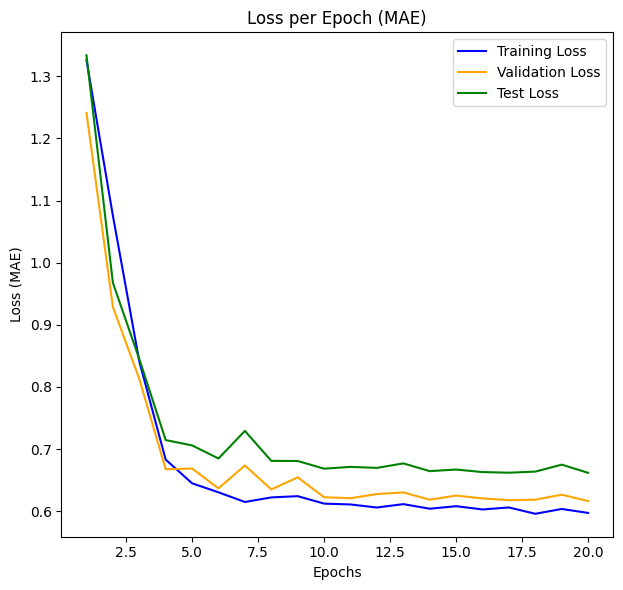

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batched_g, labels in dataloader:
            batched_g, labels = batched_g.to(device), labels.to(device)

            # Flatten labels to match model output shape
            labels = labels.unsqueeze(1)  # Reshape labels to [256, 1]
            edge_feats = batched_g.edata['feat'].float()
            num_edges = edge_feats.size(0)
            one_hot_edge_feats = torch.eye(4, device=device)[edge_feats.long()]
            logits = model(batched_g, batched_g.ndata["feat"], batched_g.ndata["PE"], one_hot_edge_feats)
            loss = nn.L1Loss()(logits, labels)  # MAE loss
            total_loss += loss.item()

            y_true.append(labels.cpu().numpy())
            y_pred.append(logits.cpu().numpy())

    # Calculate MAE
    total_loss /= len(dataloader)
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    #mae = mean_absolute_error(y_true, y_pred)  # MAE for evaluation

    return total_loss




def train(model, train_dataloader, val_dataloader, test_dataloader, device, num_epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.01, verbose=True
)
    loss_fcn = nn.L1Loss()  # Use Mean Absolute Error (MAE) for loss
    early_stopping = EarlyStopping(patience=3)

    # Track loss and MAE
    train_losses = []
    val_losses = []
    test_losses = []
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batched_g, labels in train_dataloader:
            batched_g, labels = batched_g.to(device), labels.to(device)

            # Flatten labels to match model output shape
            labels = labels.unsqueeze(1)  # Reshape labels to [256, 1]

            optimizer.zero_grad()
            edge_feats = batched_g.edata['feat'].float()
            num_edges = edge_feats.size(0)
            one_hot_edge_feats = torch.eye(4, device=device)[edge_feats.long()]
            logits = model(batched_g, batched_g.ndata["feat"], batched_g.ndata["PE"], one_hot_edge_feats)
            loss = loss_fcn(logits, labels)  # MAE loss
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)

        # Evaluate on validation and test datasets
        val_loss = evaluate(model, val_dataloader, device)
        scheduler.step(val_loss)
        test_loss = evaluate(model, test_dataloader, device)

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        # Log epoch results
        print(
            f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}"
        )

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break


    # Plot Losses and MAE
    plot_loss_and_mae(train_losses, val_losses, test_losses)



# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
model = GTModel(out_size=1).to(device)

# Start training
train(model,  train_dataloader, val_dataloader, test_dataloader, device)